Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   DEALER ID                            10000 non-null  int64  
 1   APPLICATION LOGIN DATE               10000 non-null  object 
 2   HDB BRANCH NAME                      9999 non-null   object 
 3   HDB BRANCH STATE                     9146 non-null   object 
 4   FIRST NAME                           10000 non-null  object 
 5   MIDDLE NAME                          2855 non-null   object 
 6   LAST NAME                            9319 non-null   object 
 7   mobile                               10000 non-null  int64  
 8   AADHAR VERIFIED                      10000 non-null  object 
 9   Cibil Score                          5703 non-null   object 
 10  MOBILE VERIFICATION                  10000 non-null  bool   
 11  DEALER NAM

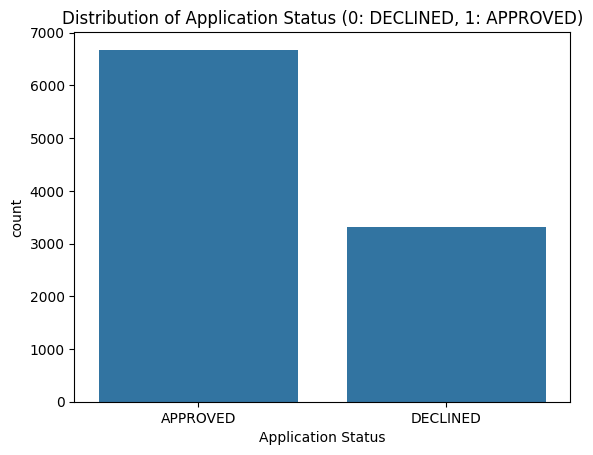

C:\Users\Divyansh\AppData\Local\Temp\ipykernel_16320\356119963.py:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cibil Score'].fillna(df['Cibil Score'].median(), inplace=True)
C:\Users\Divyansh\AppData\Local\Temp\ipykernel_16320\356119963.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['APPLICATION LOGIN DATE'] = pd.to_datetime(df['APPLICATION LOGIN DATE'], errors='coerce')


DEALER ID               float64
HDB BRANCH NAME         float64
HDB BRANCH STATE        float64
FIRST NAME              float64
MIDDLE NAME             float64
                         ...   
Loan_to_Income_Ratio    float64
Creditworthiness        float64
Has_Social_Media        float64
Age_Group               float64
Assets_Owned            float64
Length: 61, dtype: object
Model performance on validation set:
              precision    recall  f1-score   support

    APPROVED       0.90      0.92      0.91      1327
    DECLINED       0.84      0.79      0.82       673

    accuracy                           0.88      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.88      0.88      0.88      2000

Predictions saved to predictions.csv


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report
import numpy as np

# Load the data files
train_data_path = 'Assignment_Train.csv'  # Update the path if necessary
test_data_path = 'Assignment_Test.csv'    # Update the path if necessary

# Reading the data files
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Target variable
target_column = 'Application Status'

# EDA Section: Exploratory Data Analysis
print("Basic Information:")
print(train_data.info())  # Basic info about dataset

print("\nSummary statistics for numerical columns:")
print(train_data.describe())  # Summary of numerical columns

# Checking for missing values
missing_values = train_data.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])

# Visualizing target variable distribution
sns.countplot(x=target_column, data=train_data)
plt.title('Distribution of Application Status (0: DECLINED, 1: APPROVED)')
plt.show()

# Feature Engineering
def feature_engineering(df):
    # 1. Handling Date Columns (if available)
    if 'APPLICATION LOGIN DATE' in df.columns:
        df['APPLICATION LOGIN DATE'] = pd.to_datetime(df['APPLICATION LOGIN DATE'], errors='coerce')
        df['App_Login_Year'] = df['APPLICATION LOGIN DATE'].dt.year
        df['App_Login_Month'] = df['APPLICATION LOGIN DATE'].dt.month
        df['App_Login_Day'] = df['APPLICATION LOGIN DATE'].dt.day
        df.drop('APPLICATION LOGIN DATE', axis=1, inplace=True)

    # 2. Loan-to-Income Ratio (if features related to income and loan amount exist)
    if 'APPLIED AMOUNT' in df.columns and 'TOTAL ASSET COST' in df.columns:
        df['Loan_to_Income_Ratio'] = df['APPLIED AMOUNT'] / df['TOTAL ASSET COST']
    
    # 3. Creditworthiness (Using Cibil Score and other relevant features)
    if 'Cibil Score' in df.columns:
        # Convert Cibil Score to numeric, invalid parsing will be set as NaN
        df['Cibil Score'] = pd.to_numeric(df['Cibil Score'], errors='coerce')
        # Fill missing or invalid Cibil Scores with median value (or any strategy you prefer)
        df['Cibil Score'].fillna(df['Cibil Score'].median(), inplace=True)
        # Normalize Cibil Score between 0 and 1 (assuming max Cibil Score is 300)
        df['Creditworthiness'] = df['Cibil Score'] / 300

    # 4. Social Media Presence (Based on social media columns)
    social_media_cols = [col for col in df.columns if 'Phone Social Premium' in col]
    df['Has_Social_Media'] = df[social_media_cols].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

    # 5. Binning Age (if AGE column exists)
    if 'AGE' in df.columns:
        bins = [18, 30, 45, 60, 100]
        labels = ['18-30', '31-45', '46-60', '60+']
        df['Age_Group'] = pd.cut(df['AGE'], bins=bins, labels=labels)

    # 6. Total Assets Owned (Combining relevant asset columns)
    if 'TOTAL ASSET COST' in df.columns:
        df['Assets_Owned'] = df['TOTAL ASSET COST']  # More complex logic can be applied if other asset columns exist

    return df


# Ensure feature engineering is applied correctly
train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

# Split the train data into features and target
X_train = train_data.drop(columns=[target_column])
y_train = train_data[target_column]

# Handle missing values
categorical_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Impute missing values
categorical_imputer = SimpleImputer(strategy='most_frequent')
numerical_imputer = SimpleImputer(strategy='median')

X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])
X_train[numerical_cols] = numerical_imputer.fit_transform(X_train[numerical_cols])

# Handle the test data similarly
test_data[categorical_cols] = categorical_imputer.transform(test_data[categorical_cols])
test_data[numerical_cols] = numerical_imputer.transform(test_data[numerical_cols])

# Encode categorical variables using OrdinalEncoder
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

X_train[categorical_cols] = ordinal_encoder.fit_transform(X_train[categorical_cols])
test_data[categorical_cols] = ordinal_encoder.transform(test_data[categorical_cols])

# Ensure there are no remaining non-numeric columns in X_train
print(X_train.dtypes)

# Split the training data into train and validation sets for evaluation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the RandomForestClassifier model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_split, y_train_split)

# Validate the model on the validation set
y_val_pred = model.predict(X_val_split)

# Print the performance report on the validation set
performance_report = classification_report(y_val_split, y_val_pred)
print("Model performance on validation set:")
print(performance_report)

# Drop 'UID' from test_data to avoid unseen feature names
if 'UID' in test_data.columns:
    uid_column = test_data['UID']
    test_data = test_data.drop(columns=['UID'])

# Make sure test_data contains only the columns that were in X_train
test_data = test_data[X_train.columns]

# Make predictions on the test data
test_predictions = model.predict(test_data)

# Convert predictions to "APPROVED" or "DECLINED"
test_predictions = ["APPROVED" if pred == 1 else "DECLINED" for pred in test_predictions]

# Prepare the output in the required format (UID, Prediction)
output = pd.DataFrame({'UID': uid_column, 'Prediction': test_predictions})

# Save the output as a CSV file
output.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")


